# Rainfall time-series dataset released by WFP 

The data regarding the rainfalls are provided by the WFP: https://dataviz.vam.wfp.org/seasonal_explorer/rainfall_vegetation/visualizations#

We have collected only the data of the adminstratas considered in the *Food Consumption Score* and *Reduced Coping Strategy Index* surveys.

In [1]:
import pandas as pd
import numpy as np
import ntpath
import glob

In [2]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../../packages/")
from map_plot import draw_adminstratas
from TsIP.TsIP import TsIP

In [3]:
# Define the path where the results arising from this analysis will be saved.
PATH_TO_SAVE_DATA = "./output_timeseries/"

In [4]:
# Read the data released by wfp regarding the rainfall stored in the 'wfp_data' folder.
path = "./wfp_data/"
all_folders = glob.glob(path + "*")

dfs = []

for folder in all_folders:
    country = ntpath.basename(folder).split(".")[0]
    all_subfolders = glob.glob(path + country + "/Rainfall/*")
    for subfolder in all_subfolders:
        adminstrata = ntpath.basename(subfolder).split(".")[0]
        # All the files of the years.
        all_files = glob.glob(subfolder + "/*.csv")
        for filename in all_files:
            df = pd.read_csv(filename, index_col = False)
            df["AdminStrata"] = adminstrata
            df["Country"] = country
            dfs.append(df)

In [5]:
# Concatenate data.
df = pd.concat(dfs, axis = 0, ignore_index = True)
# Delete the duplicate rows of the dataframe (some date have duplicate information due to loading data from different files).
df.drop_duplicates(inplace = True)
df.reset_index(drop = True, inplace = True)
df.head()

,Year,Month,Dekad,1 Month Anomaly (%),3 Months Anomaly (%),Value,Average,AdminStrata,Country
0,2016,1,1,100.0,189.592966,0.00,0.0,Boucle-Du-Mouhoun,Burkina Faso
1,2016,1,2,100.0,124.756206,0.00,0.0,Boucle-Du-Mouhoun,Burkina Faso
2,2016,1,3,100.0,103.215912,0.00,0.0,Boucle-Du-Mouhoun,Burkina Faso
3,2016,2,1,100.0,100.129909,0.00,0.0,Boucle-Du-Mouhoun,Burkina Faso
4,2016,2,2,100.1,100.159968,0.01,0.0,Boucle-Du-Mouhoun,Burkina Faso


### Brief items description

- *Year*: reference year of the data collection.
- *Month*: reference month of the data collection.
- *Dekad*: reference month dekad of the data collection: these correspond to the calendar dates 1-10, 11-20, and 21-end of each month.
- *1 Month Anomaly (%)*: the value of 1 month rainfall anomaly in the reference period.
- *3 Months Anomaly (%)*: the value of 3 month rainfall anomaly in the reference period.
- *Value*: rainfall amount in the reference period.
- *Average*: long-term rainfall average for the same period.
- *AdminStrata*: the adminstrata information of the reference country.
- *Country*: the country information.

### Country item

In [6]:
print("The countries are:", ", ".join(df.Country.unique()))

The countries are: Burkina Faso, Nigeria, Syria, Yemen


### AdminStrata item

In [7]:
AdminStratas = df.groupby("Country")["AdminStrata"].unique()

- **Yemen (YEM)**: the governorates of Yemen are 22, including the capital Sana'a (Amanat Al Asimah) and Socotra archipelago.  The rainfall dataframe has the values of all the governorates.

In [8]:
print(AdminStratas["Yemen"].shape)
AdminStratas["Yemen"]

(22,)


array(['Abyan', 'Aden', 'Al Bayda', "Al Dhale'e", 'Al Hudaydah',
       'Al Jawf', 'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran',
       'Dhamar', 'Hadramaut', 'Hajjah', 'Ibb', 'Lahj', 'Marib', 'Raymah',
       "Sa'ada", "Sana'a", 'Shabwah', 'Socotra', 'Taizz'], dtype=object)

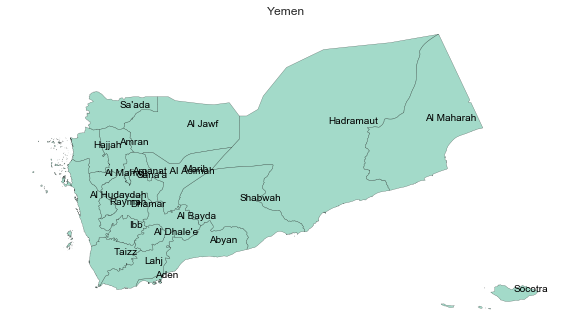

In [9]:
draw_adminstratas("Yemen", AdminStratas["Yemen"], "../Shape Files/shapefiles/Yemen/administrative level 1", figsize = (10, 7), cmap = "Set2", annotation = True)

- **Nigeria (NGA)**: Nigeria is divided into 36 states. It also includes The Federal Capital Territory that is not a state and it is under the direct control of the federal government. The AdminStrata items of the rainfall dataframe cover 3 states: Adamawa, Borno and Yobe.

In [10]:
print(AdminStratas["Nigeria"].shape)
AdminStratas["Nigeria"]

(3,)


array(['Adamawa', 'Borno', 'Yobe'], dtype=object)

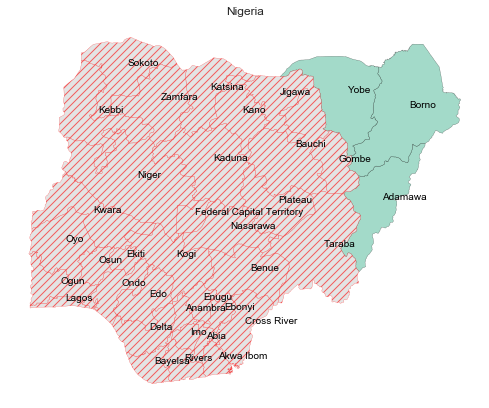

In [11]:
draw_adminstratas("Nigeria", AdminStratas["Nigeria"], "../Shape Files/shapefiles/Nigeria/administrative level 1", figsize = (10, 7), cmap = "Set2", annotation = True)

- **Syria (SYR)**: the governatores of the Syria country are 14. The rainfall dataframe has the values of 13 governorates (Idleb governatore not included).

In [12]:
print(AdminStratas["Syria"].shape)
AdminStratas["Syria"]

(13,)


array(['Al-Hasakeh', 'Aleppo', 'Ar-Raqqa', 'As-Sweida', 'Damascus',
       "Dar'a", 'Deir-ez-Zor', 'Hama', 'Homs', 'Lattakia', 'Quneitra',
       'Rural Damascus', 'Tartous'], dtype=object)

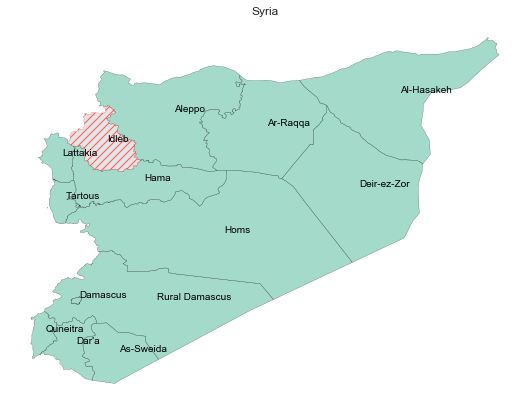

In [13]:
draw_adminstratas("Syria", AdminStratas["Syria"], "../Shape Files/shapefiles/Syria/administrative level 1", figsize = (10, 7), cmap = "Set2", annotation = True)

- **Burkina Faso (BFA)**: Burkina Faso is divided into 13 administrative regions. The rainfall dataframe has the values of all 13 regions.

In [14]:
print(AdminStratas["Burkina Faso"].shape)
AdminStratas["Burkina Faso"]

(13,)


array(['Boucle-Du-Mouhoun', 'Cascades', 'Centre', 'Centre-Est',
       'Centre-Nord', 'Centre-Ouest', 'Centre-Sud', 'Est',
       'Hauts-Bassins', 'Nord', 'Plateau-Central', 'Sahel', 'Sud-Ouest'],
      dtype=object)

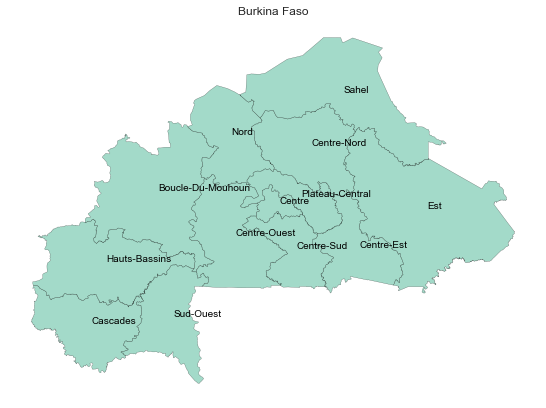

In [15]:
draw_adminstratas("Burkina Faso", AdminStratas["Burkina Faso"], "../Shape Files/shapefiles/Burkina Faso/administrative level 1", figsize = (10, 7), cmap = "Set2", annotation = True)

## Creation of the time-series

We create the time-series using the information: 1 Month Anomaly (%), 3 Month Anomaly (%) and the amount of rainfall.

In [16]:
# Convert the dekads to proper pandas datetime format.
# These correspond to the calendar dates 1-10, 11-20, and 21-end of each month.
def dekad_to_day(row):
    date = pd.to_datetime(str(row["Year"]) + "-" + str(row["Month"]) + "-01")
    end_month = date.days_in_month
    dekad = row.Dekad   
    if dekad == 1:
        return 10
    if dekad == 2:
        return 20
    if dekad == 3:
        return end_month
    
df["Day"] = df.apply(dekad_to_day, axis = 1)
df.head()

,Year,Month,Dekad,1 Month Anomaly (%),3 Months Anomaly (%),Value,Average,AdminStrata,Country,Day
0,2016,1,1,100.0,189.592966,0.00,0.0,Boucle-Du-Mouhoun,Burkina Faso,10
1,2016,1,2,100.0,124.756206,0.00,0.0,Boucle-Du-Mouhoun,Burkina Faso,20
2,2016,1,3,100.0,103.215912,0.00,0.0,Boucle-Du-Mouhoun,Burkina Faso,31
3,2016,2,1,100.0,100.129909,0.00,0.0,Boucle-Du-Mouhoun,Burkina Faso,10
4,2016,2,2,100.1,100.159968,0.01,0.0,Boucle-Du-Mouhoun,Burkina Faso,20


In [17]:
# Adjusting the dataframe.
df.drop(columns = "Dekad", inplace = True)
data = pd.to_datetime(df[["Year", "Month", "Day"]])
df.insert(1, "Datetime", data)
df.drop(["Year", "Month", "Day"], axis = 1, inplace = True)
df.sort_values("Datetime", ascending = True, inplace = True) 
df.reset_index(drop = True, inplace = True)
df.head()

,Datetime,1 Month Anomaly (%),3 Months Anomaly (%),Value,Average,AdminStrata,Country
0,2016-01-10,100.000000,189.592966,0.000,0.000,Boucle-Du-Mouhoun,Burkina Faso
1,2016-01-10,102.645239,157.964602,0.093,0.000,Sud-Ouest,Burkina Faso
2,2016-01-10,108.308363,124.123587,3.601,3.186,Hadramaut,Yemen
3,2016-01-10,100.000000,130.814778,0.000,0.000,Sahel,Burkina Faso
4,2016-01-10,117.606962,129.937515,1.314,0.943,Hajjah,Yemen


In [18]:
# Resampling the data to daily frequency.
df = df.groupby(["Country", "AdminStrata"]).apply(lambda group: group.set_index("Datetime").resample("D").mean()).reset_index()
df.reset_index(drop = True, inplace = True)
df.head()

,Country,AdminStrata,Datetime,1 Month Anomaly (%),3 Months Anomaly (%),Value,Average
0,Burkina Faso,Boucle-Du-Mouhoun,2016-01-10,100.0,189.592966,0.0,0.0
1,Burkina Faso,Boucle-Du-Mouhoun,2016-01-11,NaN,NaN,NaN,NaN
2,Burkina Faso,Boucle-Du-Mouhoun,2016-01-12,NaN,NaN,NaN,NaN
3,Burkina Faso,Boucle-Du-Mouhoun,2016-01-13,NaN,NaN,NaN,NaN
4,Burkina Faso,Boucle-Du-Mouhoun,2016-01-14,NaN,NaN,NaN,NaN


In [19]:
# Rename some columns.
df.rename(columns = {"3 Months Anomaly (%)": "3 Months Anomaly (%) Rainfall", "Value": "Rainfall (mm)", "1 Month Anomaly (%)": "1 Month Anomaly (%) Rainfall"}, inplace = True)
# Delete average column (not of interest).
df.drop(columns = "Average", inplace = True)

In [20]:
# Create multi-index column dataframe.
df = df.set_index(["Datetime", "Country", "AdminStrata"]).unstack(["Country", "AdminStrata"]).reorder_levels([1, 2, 0], axis = 1).sort_index(axis = 1, level = [0, 1, 2])
df.columns.rename("Country", level = 0, inplace = True)
df.columns.rename("AdminStrata", level = 1, inplace = True)
df.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
df.index.freq = freq
df.head()

Country                     Burkina Faso                                \
AdminStrata            Boucle-Du-Mouhoun                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                         100.0                    189.592966   
2016-01-11                           NaN                           NaN   
2016-01-12                           NaN                           NaN   
2016-01-13                           NaN                           NaN   
2016-01-14                           NaN                           NaN   

Country                                                 \
AdminStrata                                   Cascades   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2016-01-10            0.0                    109.51391   
2016-01-11            NaN                          NaN   
2016-01-12            NaN                          NaN   
2016-01-13            NaN                          NaN   
2016-01-14            NaN                          NaN   

Country                                                  \
AdminStrata                                               
Indicator   3 Months Anomaly (%) Rainfall Rainfall (mm)   
Datetime                                                  
2016-01-10                     174.733681         0.725   
2016-01-11                            NaN           NaN   
2016-01-12                            NaN           NaN   
2016-01-13                            NaN           NaN   
2016-01-14                            NaN           NaN   

Country                                                                 \
AdminStrata                       Centre                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                         100.0                    155.165163   
2016-01-11                           NaN                           NaN   
2016-01-12                           NaN                           NaN   
2016-01-13                           NaN                           NaN   
2016-01-14                           NaN                           NaN   

Country                                                 ...         Yemen  \
AdminStrata                                 Centre-Est  ...        Sana'a   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall  ... Rainfall (mm)   
Datetime                                                ...                 
2016-01-10            0.0                   101.179528  ...         1.236   
2016-01-11            NaN                          NaN  ...           NaN   
2016-01-12            NaN                          NaN  ...           NaN   
2016-01-13            NaN                          NaN  ...           NaN   
2016-01-14            NaN                          NaN  ...           NaN   

Country                                                                 \
AdminStrata                      Shabwah                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                    104.417434                    119.919683   
2016-01-11                           NaN                           NaN   
2016-01-12                           NaN                           NaN   
2016-01-13                           NaN                           NaN   
2016-01-14                           NaN                           NaN   

Country                                                 \
AdminStrata                                    Socotra   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2016-01-10        

In [21]:
# Keep the dekads date.
df = df.loc[(df.index.day == 10) | (df.index.day == 20) | (df.index.is_month_end)]
df = df.groupby(axis = 1, level = [0, 1, 2], group_keys = False).apply(lambda x: x.loc[x.first_valid_index():x.last_valid_index()])
df.head()

Country                     Burkina Faso                                \
AdminStrata            Boucle-Du-Mouhoun                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                         100.0                    189.592966   
2016-01-20                         100.0                    124.756206   
2016-01-31                         100.0                    103.215912   
2016-02-10                         100.0                    100.129909   
2016-02-20                         100.1                    100.159968   

Country                                                 \
AdminStrata                                   Cascades   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2016-01-10           0.00                   109.513910   
2016-01-20           0.00                   108.335820   
2016-01-31           0.00                   109.007664   
2016-02-10           0.00                   104.553021   
2016-02-20           0.01                   103.605747   

Country                                                  \
AdminStrata                                               
Indicator   3 Months Anomaly (%) Rainfall Rainfall (mm)   
Datetime                                                  
2016-01-10                     174.733681         0.725   
2016-01-20                     144.630804         0.055   
2016-01-31                     109.390052         0.172   
2016-02-10                     107.696880         0.451   
2016-02-20                     117.608431         0.698   

Country                                                                 \
AdminStrata                       Centre                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                         100.0                    155.165163   
2016-01-20                         100.0                    119.614191   
2016-01-31                         100.0                    100.098396   
2016-02-10                         100.0                    100.000000   
2016-02-20                         100.0                    100.000000   

Country                                                 ...         Yemen  \
AdminStrata                                 Centre-Est  ...        Sana'a   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall  ... Rainfall (mm)   
Datetime                                                ...                 
2016-01-10            0.0                   101.179528  ...         1.236   
2016-01-20            0.0                   101.049790  ...         0.831   
2016-01-31            0.0                   100.000000  ...         1.219   
2016-02-10            0.0                   100.000000  ...         1.746   
2016-02-20            0.0                   100.099731  ...         1.861   

Country                                                                 \
AdminStrata                      Shabwah                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                    104.417434                    119.919683   
2016-01-20                    105.136986                    119.133376   
2016-01-31                    104.796892                    118.441903   
2016-02-10                    105.401652                    109.396981   
2016-02-20                    106.172748                    109.209793   

Country                                                 \
AdminStrata                                    Socotra   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2016-01-10        

In [22]:
# Now check if it is necessary interpolate the nan values at dekadly frequency.
# Check if the dataframe contains NaN values in correspondence of the dekades.
print("Check if the dataframe contains NaN values:")
check_nan = df.groupby(axis = 1, level = [0, 1, 2]).apply(lambda x: x.loc[x.first_valid_index():x.last_valid_index()].isnull().sum(axis = 1).sum())
check_nan

Check if the dataframe contains NaN values:


Country       AdminStrata        Indicator                    
Burkina Faso  Boucle-Du-Mouhoun  1 Month Anomaly (%) Rainfall     0
                                 3 Months Anomaly (%) Rainfall    0
                                 Rainfall (mm)                    0
              Cascades           1 Month Anomaly (%) Rainfall     0
                                 3 Months Anomaly (%) Rainfall    0
                                                                 ..
Yemen         Socotra            3 Months Anomaly (%) Rainfall    0
                                 Rainfall (mm)                    0
              Taizz              1 Month Anomaly (%) Rainfall     0
                                 3 Months Anomaly (%) Rainfall    0
                                 Rainfall (mm)                    0
Length: 153, dtype: int64

In [23]:
# Total nan values.
check_nan.sum()

0

In [24]:
# Resample data to daily level (as before) reobtaining the dekadly frequency.
df_dekad = df.groupby(axis = 1, level = [0, 1, 2], group_keys = False).resample("D").mean()
freq = "D"
df_dekad.index.freq = freq
df_dekad.head()

Country                     Burkina Faso                                \
AdminStrata            Boucle-Du-Mouhoun                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                         100.0                    189.592966   
2016-01-11                           NaN                           NaN   
2016-01-12                           NaN                           NaN   
2016-01-13                           NaN                           NaN   
2016-01-14                           NaN                           NaN   

Country                                                 \
AdminStrata                                   Cascades   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2016-01-10            0.0                    109.51391   
2016-01-11            NaN                          NaN   
2016-01-12            NaN                          NaN   
2016-01-13            NaN                          NaN   
2016-01-14            NaN                          NaN   

Country                                                  \
AdminStrata                                               
Indicator   3 Months Anomaly (%) Rainfall Rainfall (mm)   
Datetime                                                  
2016-01-10                     174.733681         0.725   
2016-01-11                            NaN           NaN   
2016-01-12                            NaN           NaN   
2016-01-13                            NaN           NaN   
2016-01-14                            NaN           NaN   

Country                                                                 \
AdminStrata                       Centre                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                         100.0                    155.165163   
2016-01-11                           NaN                           NaN   
2016-01-12                           NaN                           NaN   
2016-01-13                           NaN                           NaN   
2016-01-14                           NaN                           NaN   

Country                                                 ...         Yemen  \
AdminStrata                                 Centre-Est  ...        Sana'a   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall  ... Rainfall (mm)   
Datetime                                                ...                 
2016-01-10            0.0                   101.179528  ...         1.236   
2016-01-11            NaN                          NaN  ...           NaN   
2016-01-12            NaN                          NaN  ...           NaN   
2016-01-13            NaN                          NaN  ...           NaN   
2016-01-14            NaN                          NaN  ...           NaN   

Country                                                                 \
AdminStrata                      Shabwah                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                    104.417434                    119.919683   
2016-01-11                           NaN                           NaN   
2016-01-12                           NaN                           NaN   
2016-01-13                           NaN                           NaN   
2016-01-14                           NaN                           NaN   

Country                                                 \
AdminStrata                                    Socotra   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2016-01-10        

In [25]:
# Plot the time-series.
TsIP(df_dekad).interactive_plot_df(matplotlib = False, style = "mix", yaxis = "Rainfall", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [26]:
# Now save the time-series of each country keeping as indeces for each time-series the own first and last index.
def save(group, name):
    country = group.name
    group = group[country]
    # Adjust time-series group.
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    # Save.
    group.to_csv(PATH_TO_SAVE_DATA + country + "/" + name + ".csv", index_label = False)

In [27]:
df_dekad.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_rainfall-dekad"));

## Adjustment of the rainfall time-series to the daily time coverage of the FCS & rCSI surveys

We get the dataframe with daily frequency filling nan values (because we have information only for the dekades of the month) based on previous value dekad. More precisely, being the values of the dekad the total amount of rainfall happened in that interval we divide it for the days of the range of the dekad. For the anomalies time-series, we simply adopt a linear interpolation. Then, we adapt the current data according to the data collection of the FCS & rCSI surveys.

In [28]:
def daily_fit(group):
    indicator = group.name[2]
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    if indicator == "Rainfall (mm)":
        # We get the group with time-step of the day filling nan values with previous value dekad.
        group = group.fillna(method = "bfill")
        # Furthermore, being the values of the dekaed the tot rainfall happened in that interval we divide for the days in the range of the corresponding dekad.
        def dekad_day_norm(row):
            if row.name.day >= 1 or row.name.day <= 10:
                return row/10
            if row.name.day >= 11 or row.name.day <= 20:
                return row/10
            if row.name.day >= 21:
                return row/(row.name.days_in_month-20)
        group = group.apply(dekad_day_norm, axis = 1)
    else:
        group = group.interpolate(method = "linear")
        
    return group

df_fit_day = df_dekad.groupby(axis = 1, level = [0, 1, 2], group_keys = False).apply(daily_fit)
df_fit_day.head()

Country                     Burkina Faso                                \
AdminStrata            Boucle-Du-Mouhoun                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                         100.0                    189.592966   
2016-01-11                         100.0                    183.109290   
2016-01-12                         100.0                    176.625614   
2016-01-13                         100.0                    170.141938   
2016-01-14                         100.0                    163.658262   

Country                                                 \
AdminStrata                                   Cascades   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2016-01-10            0.0                   109.513910   
2016-01-11            0.0                   109.396101   
2016-01-12            0.0                   109.278292   
2016-01-13            0.0                   109.160483   
2016-01-14            0.0                   109.042674   

Country                                                  \
AdminStrata                                               
Indicator   3 Months Anomaly (%) Rainfall Rainfall (mm)   
Datetime                                                  
2016-01-10                     174.733681        0.0725   
2016-01-11                     171.723393        0.0055   
2016-01-12                     168.713106        0.0055   
2016-01-13                     165.702818        0.0055   
2016-01-14                     162.692530        0.0055   

Country                                                                 \
AdminStrata                       Centre                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                         100.0                    155.165163   
2016-01-11                         100.0                    151.610065   
2016-01-12                         100.0                    148.054968   
2016-01-13                         100.0                    144.499871   
2016-01-14                         100.0                    140.944774   

Country                                                 ...         Yemen  \
AdminStrata                                 Centre-Est  ...        Sana'a   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall  ... Rainfall (mm)   
Datetime                                                ...                 
2016-01-10            0.0                   101.179528  ...        0.1236   
2016-01-11            0.0                   101.166554  ...        0.0831   
2016-01-12            0.0                   101.153581  ...        0.0831   
2016-01-13            0.0                   101.140607  ...        0.0831   
2016-01-14            0.0                   101.127633  ...        0.0831   

Country                                                                 \
AdminStrata                      Shabwah                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                    104.417434                    119.919683   
2016-01-11                    104.489390                    119.841052   
2016-01-12                    104.561345                    119.762421   
2016-01-13                    104.633300                    119.683791   
2016-01-14                    104.705255                    119.605160   

Country                                                 \
AdminStrata                                    Socotra   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2016-01-10        

In [29]:
# Read the information about the FCS survey coverage.
survey_coverage = pd.read_csv("../Food Consumption Score (FCS)/output_timeseries/survey_coverage.csv", index_col = 0)
survey_coverage["SvyDate1"], survey_coverage["SvyDate2"] = pd.to_datetime(survey_coverage["SvyDate1"]), pd.to_datetime(survey_coverage["SvyDate2"])
survey_coverage.head()

,Country,AdminStrata,SvyDate2,SvyDateRange,SvyDate1
0,Burkina Faso,Boucle-Du-Mouhoun,2019-09-08,55.0,2019-07-15
1,Burkina Faso,Boucle-Du-Mouhoun,2019-09-09,55.0,2019-07-16
2,Burkina Faso,Boucle-Du-Mouhoun,2019-09-10,55.0,2019-07-17
3,Burkina Faso,Boucle-Du-Mouhoun,2019-09-11,55.0,2019-07-18
4,Burkina Faso,Boucle-Du-Mouhoun,2019-09-12,55.0,2019-07-19


In [30]:
def SvyDate_agg(group):
    country = group.name[0]
    adminstrata = group.name[1]
    indicator = group.name[2]
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    # Ignore the adminstrata not considered in the fcs survey.
    try:
        # Information of the survey.
        svy = survey_coverage[(survey_coverage.Country == country) & (survey_coverage.AdminStrata == adminstrata)]

        if svy["SvyDate2"].iloc[-1] > group.index[-1]:
            end = group.index[-1]
        else:
            end = svy["SvyDate2"].iloc[-1]

        # Check if the window length has an unique value to speed up process.
        windows = svy["SvyDateRange"].unique()
        if len(windows) == 1:
            if indicator == "Rainfall (mm)":
                return group.rolling(int(windows[0])+1).sum().loc[svy["SvyDate2"].iloc[0]:end]  
            else:
                return group.rolling(int(windows[0])+1).mean().loc[svy["SvyDate2"].iloc[0]:end]  
        else:
            new_group = group.copy()
            for index, row in svy.iterrows():
                d1, d2 = row["SvyDate1"], row["SvyDate2"]
                # Window over the column.
                if indicator == "Rainfall (mm)":
                    new_group.loc[d2] = group.loc[d1:d2].sum()
                else:
                    new_group.loc[d2] = group.loc[d1:d2].mean()
            return new_group.loc[svy["SvyDate2"].iloc[0]:end] 
    except:
        pass
    
df_SvyWindow = df_fit_day.groupby(level = [0, 1, 2], axis = 1, group_keys = False).apply(SvyDate_agg)
df_SvyWindow.head()

Country                     Burkina Faso                                \
AdminStrata            Boucle-Du-Mouhoun                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2018-07-02                           NaN                           NaN   
2018-07-03                           NaN                           NaN   
2018-07-04                           NaN                           NaN   
2018-07-05                           NaN                           NaN   
2018-07-06                           NaN                           NaN   

Country                                                 \
AdminStrata                                   Cascades   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2018-07-02            NaN                          NaN   
2018-07-03            NaN                          NaN   
2018-07-04            NaN                          NaN   
2018-07-05            NaN                          NaN   
2018-07-06            NaN                          NaN   

Country                                                  \
AdminStrata                                               
Indicator   3 Months Anomaly (%) Rainfall Rainfall (mm)   
Datetime                                                  
2018-07-02                            NaN           NaN   
2018-07-03                            NaN           NaN   
2018-07-04                            NaN           NaN   
2018-07-05                            NaN           NaN   
2018-07-06                            NaN           NaN   

Country                                                                 \
AdminStrata                       Centre                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2018-07-02                           NaN                           NaN   
2018-07-03                           NaN                           NaN   
2018-07-04                           NaN                           NaN   
2018-07-05                           NaN                           NaN   
2018-07-06                           NaN                           NaN   

Country                                                 ...         Yemen  \
AdminStrata                                 Centre-Est  ...        Sana'a   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall  ... Rainfall (mm)   
Datetime                                                ...                 
2018-07-02            NaN                          NaN  ...        5.4919   
2018-07-03            NaN                          NaN  ...        7.0160   
2018-07-04            NaN                          NaN  ...        8.5401   
2018-07-05            NaN                          NaN  ...       10.0642   
2018-07-06            NaN                          NaN  ...       11.5883   

Country                                                                 \
AdminStrata                      Shabwah                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2018-07-02                    116.913496                    125.808795   
2018-07-03                    116.522007                    126.740336   
2018-07-04                    116.191857                    127.691843   
2018-07-05                    115.923045                    128.663316   
2018-07-06                    115.715573                    129.654756   

Country                                                 \
AdminStrata                                    Socotra   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2018-07-02        

In [31]:
# Plot the time-series.
TsIP(df_SvyWindow).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "Rainfall", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [32]:
df_SvyWindow.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_rainfall-day"));